# Визуализация связей таблиц баз данных

Этот ноутбук создает диаграммы связей (на основе внешних ключей) для баз данных `cms`, `lists` и `filestorage`.

**Требования:**
- Установленная системная утилита `graphviz` (`dot`).
- Установленные Python библиотеки: `psycopg2`, `pandas`, `graphviz`, `python-dotenv`.

In [1]:
import os
import sys
from pathlib import Path
import psycopg2
import pandas as pd
import graphviz
from dotenv import load_dotenv
from IPython.display import display, Markdown, Image

In [2]:
# Загружаем переменные окружения из .env в корне проекта
project_root = Path.cwd().parent
dotenv_path = project_root / '.env'

if not dotenv_path.exists():
    print(f"Ошибка: Файл .env не найден по пути {dotenv_path}", file=sys.stderr)
else:
    load_dotenv(dotenv_path=dotenv_path)
    print(f".env файл загружен из {dotenv_path}")

pg_user = os.getenv("PG_USER")
pg_password = os.getenv("PG_PASSWORD")
pg_host = os.getenv("PG_HOST", "localhost")
pg_port = os.getenv("PG_PORT", "5432")

# Директория для сохранения диаграмм
output_dir = project_root / "logs" / "db_diagrams"
output_dir.mkdir(parents=True, exist_ok=True)

if not all([pg_user, pg_password]):
    print("Ошибка: Переменные PG_USER и PG_PASSWORD должны быть установлены в .env.", file=sys.stderr)


.env файл загружен из /home/skitarii/PycharmProjects/chatHRD/.env


## Вспомогательные функции

In [3]:
def get_connection(db_name: str):
    """Подключается к указанной БД."""
    conn = None
    try:
        conn = psycopg2.connect(dbname=db_name, user=pg_user, password=pg_password, host=pg_host, port=pg_port)
        print(f"Успешное подключение к БД '{db_name}'.")
    except psycopg2.OperationalError as e:
        print(f"Ошибка подключения к БД '{db_name}': {e}", file=sys.stderr)
    return conn

def get_foreign_keys(conn) -> pd.DataFrame:
    """Получает информацию о внешних ключах в БД."""
    if not conn:
        return pd.DataFrame()
    query = """
        SELECT
            tc.table_name,
            kcu.column_name,
            ccu.table_name AS foreign_table_name,
            ccu.column_name AS foreign_column_name
        FROM
            information_schema.table_constraints AS tc
            JOIN information_schema.key_column_usage AS kcu
              ON tc.constraint_name = kcu.constraint_name
              AND tc.table_schema = kcu.table_schema
            JOIN information_schema.constraint_column_usage AS ccu
              ON ccu.constraint_name = tc.constraint_name
              AND ccu.table_schema = tc.table_schema
        WHERE tc.constraint_type = 'FOREIGN KEY' AND tc.table_schema = 'public';
    """
    try:
        df = pd.read_sql_query(query, conn)
        return df
    except Exception as e:
        print(f"Ошибка получения внешних ключей: {e}", file=sys.stderr)
        return pd.DataFrame()

def get_all_tables(conn) -> list[str]:
    """Возвращает список ВСЕХ пользовательских таблиц (даже без FK)."""
    # Эта функция дублирует get_tables из предыдущего ноутбука,
    # но нужна здесь для добавления узлов для всех таблиц.
    if not conn:
        return []
    query = """
        SELECT table_name
        FROM information_schema.tables
        WHERE table_schema = 'public' AND table_type = 'BASE TABLE'
        ORDER BY table_name;
    """
    try:
        df = pd.read_sql_query(query, conn)
        return df['table_name'].tolist()
    except Exception as e:
        print(f"Ошибка получения списка таблиц: {e}", file=sys.stderr)
        return []

def create_schema_diagram(fk_df: pd.DataFrame, all_tables: list[str], db_name: str, out_dir: Path):
    """Создает и сохраняет диаграмму связей Graphviz."""
    dot = graphviz.Digraph(f'{db_name}_schema', comment=f'Schema for {db_name} database')
    dot.attr(rankdir='LR') # Расположение слева направо может быть лучше для схем БД
    dot.attr('node', shape='record') # Используем 'record' для отображения таблиц

    # Добавляем все таблицы как узлы
    for table in all_tables:
        dot.node(table, label=f'{{ {table} }}') # Простой вид узла - только имя таблицы
        # При желании, можно добавить колонки: label=f'{{ {table} | col1 | col2 | ... }}'
        # Но для этого нужно будет передать сюда схему каждой таблицы

    # Добавляем ребра для внешних ключей
    for index, row in fk_df.iterrows():
        dot.edge(
            row['table_name'],
            row['foreign_table_name'],
            label=f"{row['column_name']} -> {row['foreign_column_name']}" # Подпись связи
        )

    # Сохраняем диаграмму (например, в PNG)
    output_filename = out_dir / f'{db_name}_schema'
    try:
        dot.render(output_filename, format='png', view=False, cleanup=True)
        print(f"Диаграмма сохранена в {output_filename}.png")
        return output_filename # Возвращаем путь для возможного отображения
    except graphviz.backend.ExecutableNotFound:
        print("Ошибка: Исполняемый файл Graphviz (dot) не найден.", file=sys.stderr)
        print("Пожалуйста, установите Graphviz в систему и убедитесь, что он в PATH.", file=sys.stderr)
        return None
    except Exception as e:
        print(f"Ошибка при рендеринге диаграммы: {e}", file=sys.stderr)
        return None

## Генерация диаграмм


## Генерация для базы данных: `cms`

Успешное подключение к БД 'cms'.


/tmp/ipykernel_457692/3152888833.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/tmp/ipykernel_457692/3152888833.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Обнаружено 58 внешних ключей.

Диаграмма сохранена в /home/skitarii/PycharmProjects/chatHRD/logs/db_diagrams/cms_schema.png


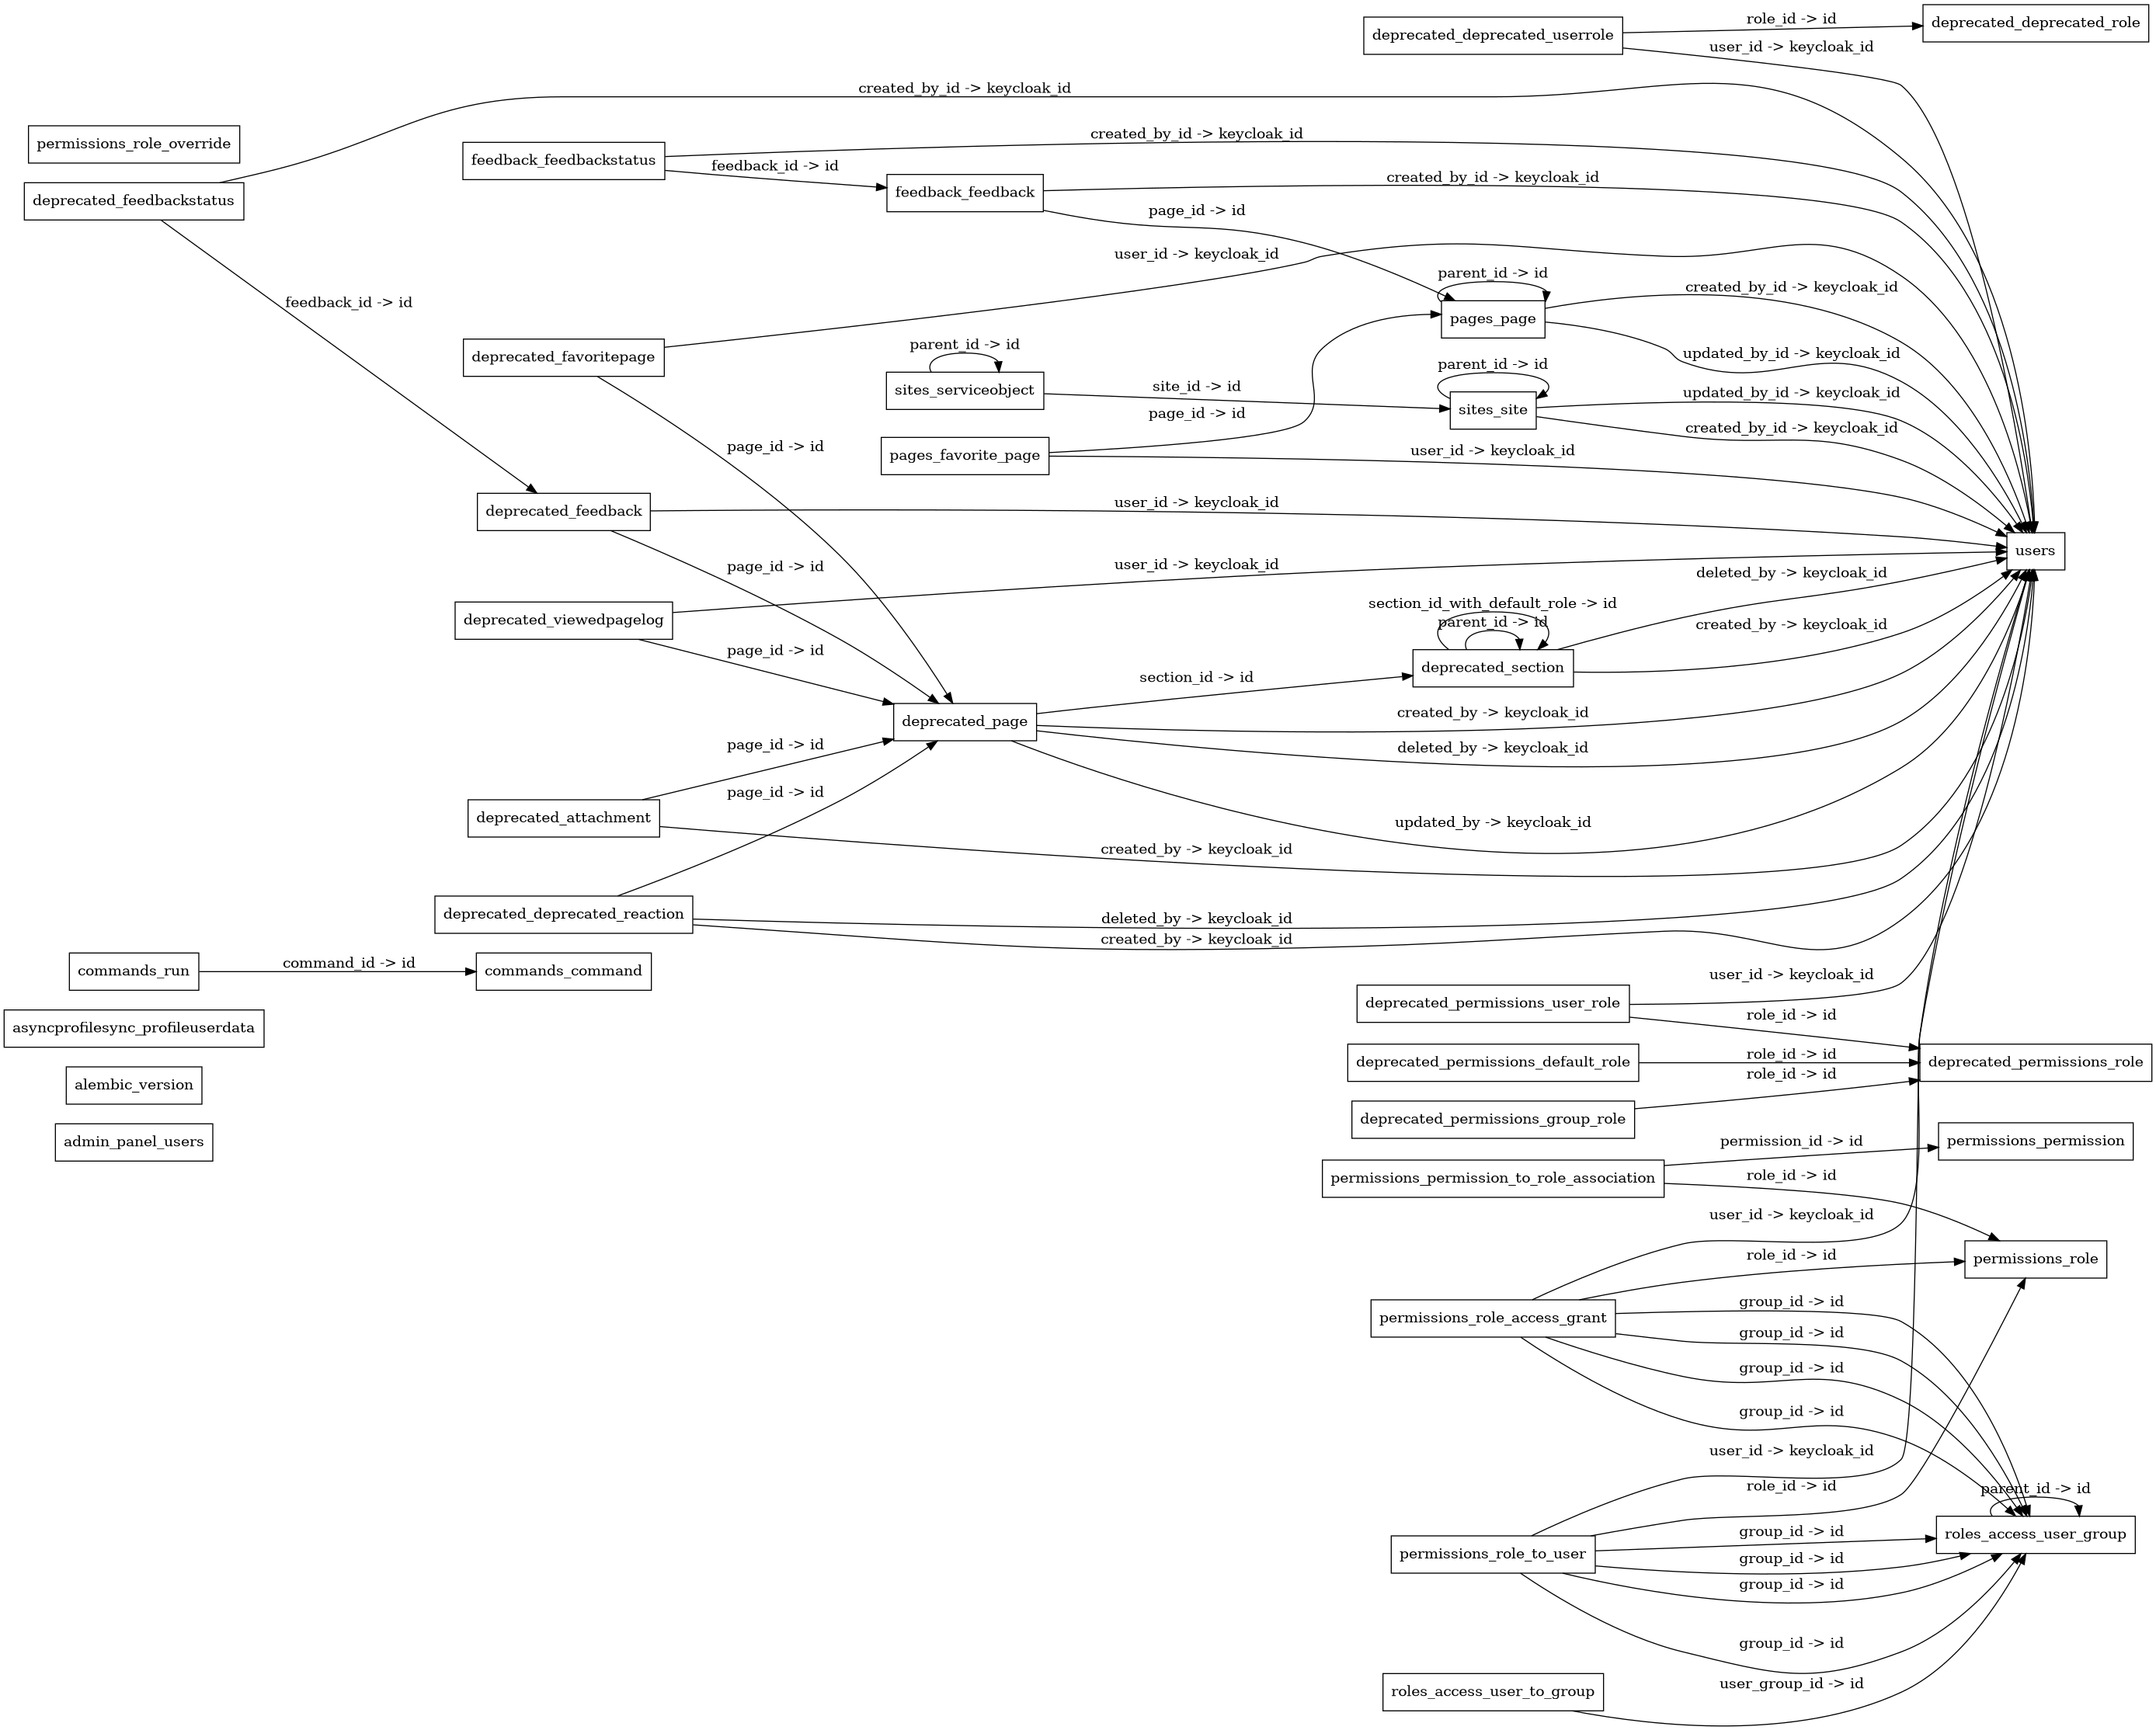

Соединение с БД 'cms' закрыто.



## Генерация для базы данных: `lists`

Успешное подключение к БД 'lists'.


/tmp/ipykernel_457692/3152888833.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/tmp/ipykernel_457692/3152888833.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Обнаружено 22 внешних ключей.

Диаграмма сохранена в /home/skitarii/PycharmProjects/chatHRD/logs/db_diagrams/lists_schema.png


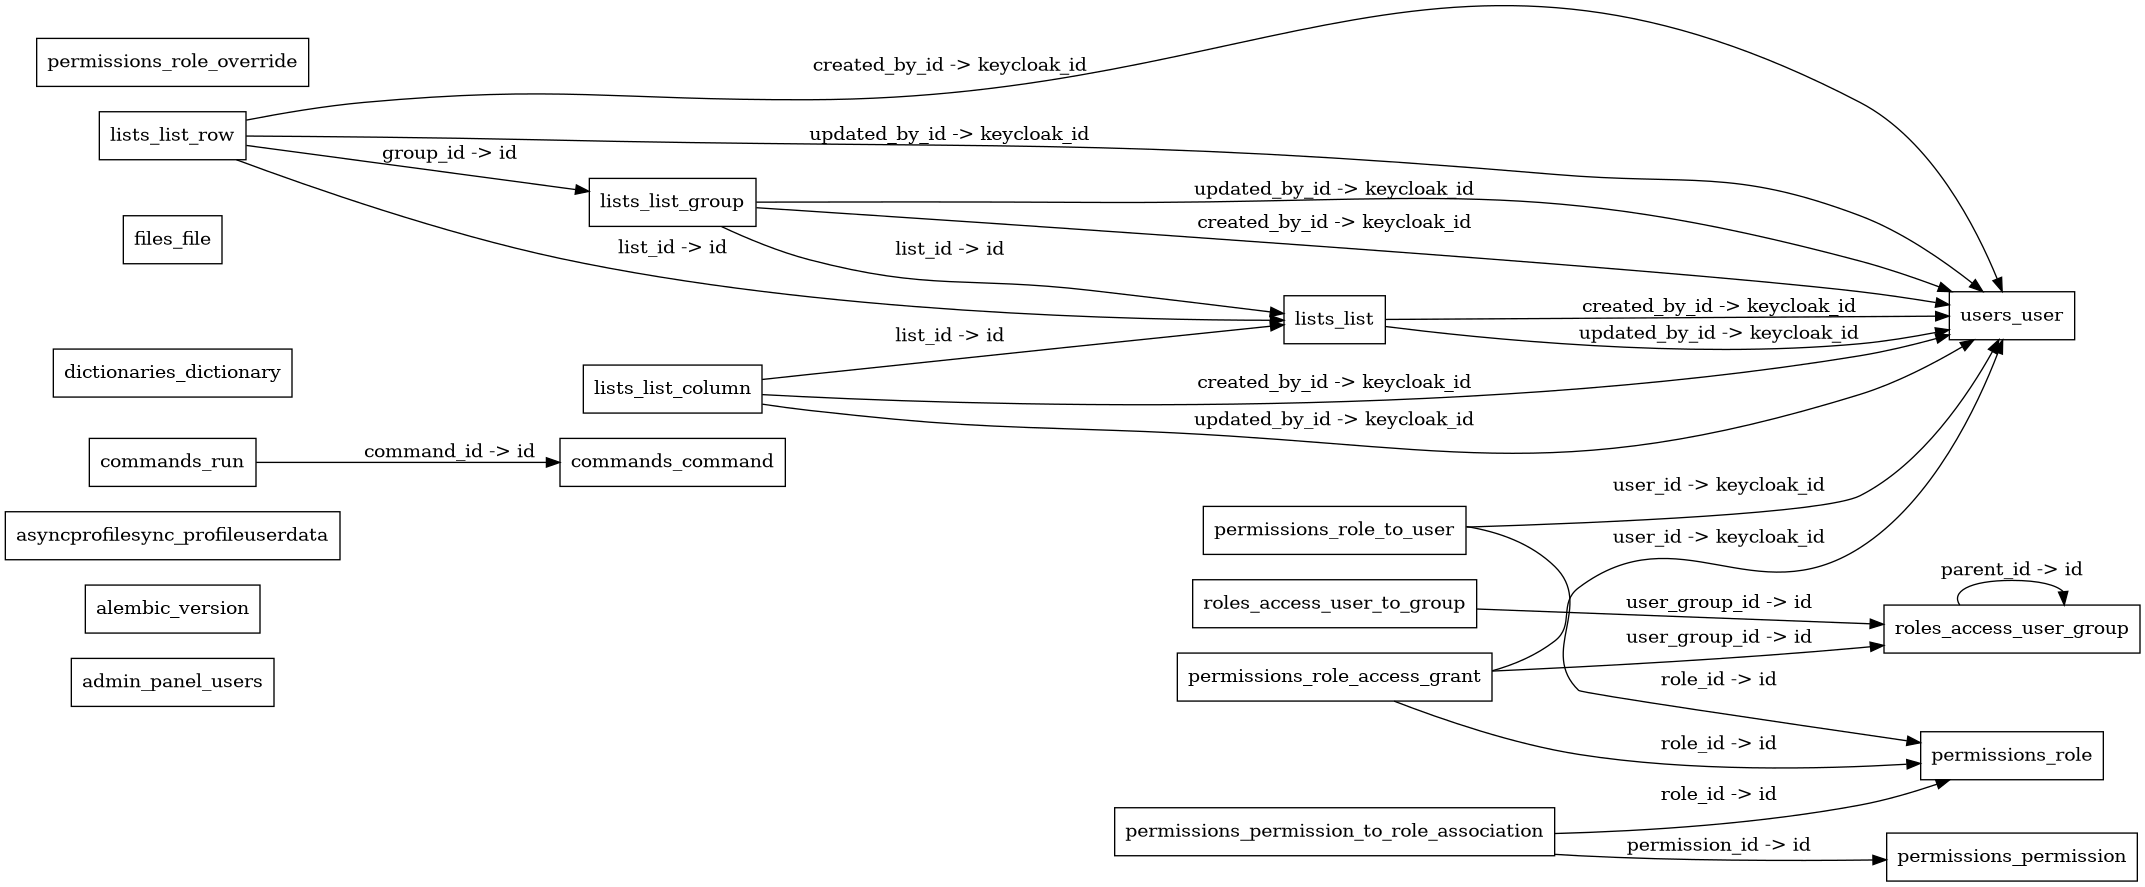

Соединение с БД 'lists' закрыто.



## Генерация для базы данных: `filestorage`

Успешное подключение к БД 'filestorage'.


/tmp/ipykernel_457692/3152888833.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/tmp/ipykernel_457692/3152888833.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Обнаружено 86 внешних ключей.

Диаграмма сохранена в /home/skitarii/PycharmProjects/chatHRD/logs/db_diagrams/filestorage_schema.png


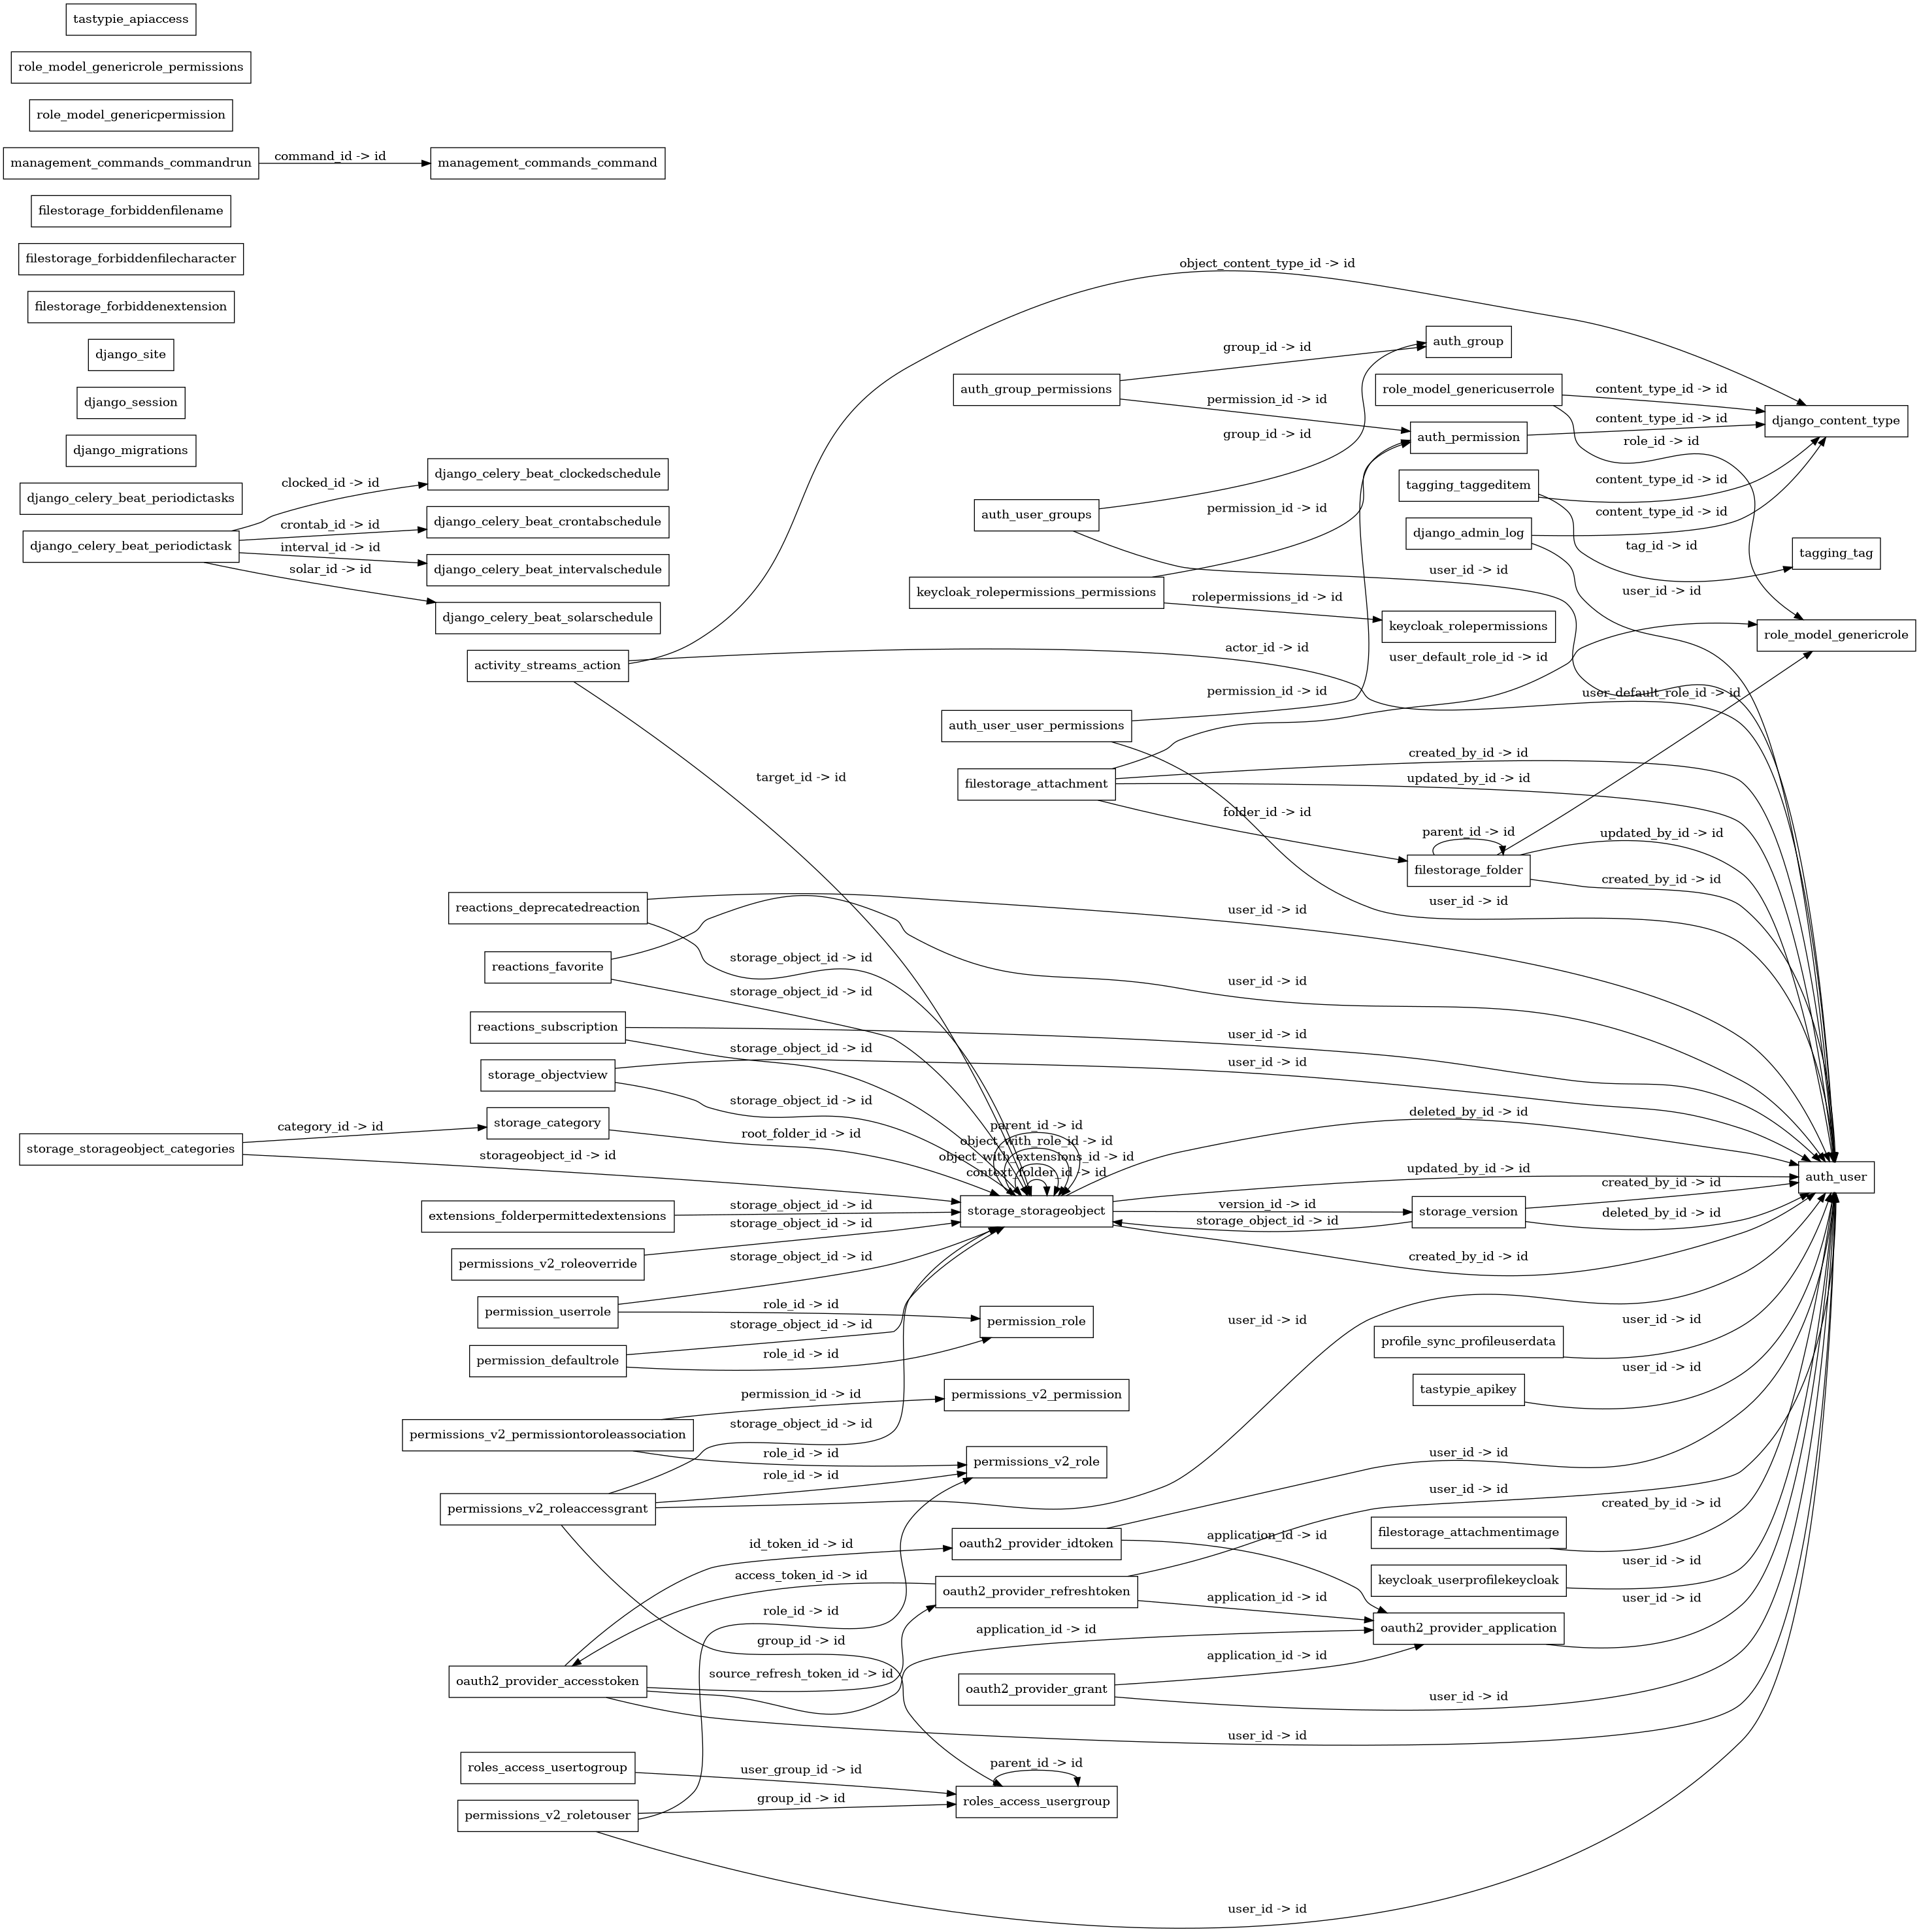

Соединение с БД 'filestorage' закрыто.

Генерация диаграмм завершена.


In [4]:
databases_to_analyze = ["cms", "lists", "filestorage"]

for db_name in databases_to_analyze:
    display(Markdown(f'\n## Генерация для базы данных: `{db_name}`'))
    conn = get_connection(db_name)

    if conn:
        all_tables = get_all_tables(conn)
        fk_df = get_foreign_keys(conn)

        if not fk_df.empty:
            display(Markdown(f'Обнаружено {len(fk_df)} внешних ключей.'))
            diagram_path = create_schema_diagram(fk_df, all_tables, db_name, output_dir)

            if diagram_path:
                 # Отображаем созданное изображение PNG
                 display(Image(filename=f'{diagram_path}.png'))

        else:
            display(Markdown('Внешние ключи не найдены.'))
            # Все равно создадим диаграмму только с узлами таблиц
            diagram_path = create_schema_diagram(pd.DataFrame(), all_tables, db_name, output_dir)
            if diagram_path:
                 display(Image(filename=f'{diagram_path}.png'))

        conn.close()
        print(f"Соединение с БД '{db_name}' закрыто.")
    else:
        display(Markdown(f'**Не удалось подключиться к БД `{db_name}`**'))

print("\nГенерация диаграмм завершена.")

In [5]:
import sys
from pathlib import Path
import pandas as pd
from IPython.display import display, Markdown # Если используешь в ноутбуке для вывода
# Нужны также функции get_connection, get_all_tables, get_foreign_keys из предыдущих примеров
# и переменные подключения к БД (pg_user, pg_password, ...)

In [6]:
def generate_mermaid_erd(fk_df: pd.DataFrame, all_tables: list[str], db_name: str) -> str:
    """Генерирует текстовое представление схемы БД в формате Mermaid ERD."""
    lines = ["erDiagram"]

    # Добавляем все таблицы
    for table in sorted(all_tables):
        lines.append(f'    {table} {{')
        # Сюда можно добавить колонки, если нужно (потребуется get_table_schema)
        # Например:
        # schema_df = get_table_schema(conn, table) # Нужно передать conn
        # for _, col_row in schema_df.iterrows():
        #     lines.append(f'        {col_row["data_type"]} {col_row["column_name"]}')
        lines.append(f'    }}') # Просто закрываем блок таблицы

    lines.append("") # Пустая строка для разделения

    # Добавляем связи (внешние ключи)
    # Сортируем для консистентности вывода
    fk_df_sorted = fk_df.sort_values(by=['table_name', 'foreign_table_name', 'column_name']).reset_index()
    for index, row in fk_df_sorted.iterrows():
        # Используем ||--o{ для обозначения связи "один (PK) ко многим (FK)"
        # Можно использовать другие символы Mermaid ERD при необходимости
        label = f"FK: {row['column_name']} -> {row['foreign_column_name']}"
        lines.append(f"    {row['table_name']} ||--o{{ {row['foreign_table_name']} : \"{label}\"")

    return "\n".join(lines)

In [7]:
# --- НАСТРОЙКИ ---
# Убедись, что эти переменные определены:
# pg_user, pg_password, pg_host, pg_port
# project_root = Path.cwd().parent # Или другой путь к корню проекта

databases_to_analyze = ["cms", "lists", "filestorage"]
output_doc_dir = project_root / "docs" # Сохраняем в документацию
output_doc_dir.mkdir(parents=True, exist_ok=True) # Создаем папку, если нет

# --- ЦИКЛ ПО БАЗАМ ДАННЫХ ---
for db_name in databases_to_analyze:
    print(f'\n## Генерация текстовой схемы для: `{db_name}`')
    conn = get_connection(db_name) # Используем твою функцию подключения

    if conn:
        all_tables = get_all_tables(conn) # Нужна твоя функция get_all_tables
        fk_df = get_foreign_keys(conn)    # Нужна твоя функция get_foreign_keys

        print(f'Найдено таблиц: {len(all_tables)}. Найдено внешних ключей: {len(fk_df)}.')

        # Генерируем Mermaid код
        mermaid_code = generate_mermaid_erd(fk_df, all_tables, db_name)

        # Сохраняем в файл .md
        output_md_path = output_doc_dir / f"db_schema_{db_name}.md"
        try:
            with open(output_md_path, 'w', encoding='utf-8') as f:
                f.write(f"# Схема базы данных: {db_name}\n\n")
                f.write("```mermaid\n")
                f.write(mermaid_code)
                f.write("\n```\n")
            print(f"Схема Mermaid сохранена в: {output_md_path}")
        except OSError as e:
            print(f"Ошибка сохранения файла {output_md_path}: {e}", file=sys.stderr)

        # Опционально: вывести код в консоль или ноутбук
        # print(f'\n### Mermaid ERD код для `{db_name}`:\n\n```mermaid\n{mermaid_code}\n```')
        # или в ноутбуке:
        # display(Markdown(f'\n### Mermaid ERD код для `{db_name}`:\n\n```mermaid\n{mermaid_code}\n```'))


        conn.close()
        print(f"Соединение с БД '{db_name}' закрыто.")
    else:
        print(f'**Не удалось подключиться к БД `{db_name}`**')

print("\nГенерация текстовых схем завершена.")


## Генерация текстовой схемы для: `cms`
Успешное подключение к БД 'cms'.
Найдено таблиц: 34. Найдено внешних ключей: 58.
Схема Mermaid сохранена в: /home/skitarii/PycharmProjects/chatHRD/docs/db_schema_cms.md
Соединение с БД 'cms' закрыто.

## Генерация текстовой схемы для: `lists`
Успешное подключение к БД 'lists'.
Найдено таблиц: 20. Найдено внешних ключей: 22.
Схема Mermaid сохранена в: /home/skitarii/PycharmProjects/chatHRD/docs/db_schema_lists.md
Соединение с БД 'lists' закрыто.

## Генерация текстовой схемы для: `filestorage`


/tmp/ipykernel_457692/3152888833.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/tmp/ipykernel_457692/3152888833.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/tmp/ipykernel_457692/3152888833.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/tmp/ipykernel_457692/3152888833.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 conne

Успешное подключение к БД 'filestorage'.
Найдено таблиц: 63. Найдено внешних ключей: 86.
Схема Mermaid сохранена в: /home/skitarii/PycharmProjects/chatHRD/docs/db_schema_filestorage.md
Соединение с БД 'filestorage' закрыто.

Генерация текстовых схем завершена.
